In [1]:
import meld_graph.experiment
import os
import numpy as np
import h5py
import matplotlib_surface_plotting as msp
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import nibabel as nb
from meld_classifier.paths import BASE_PATH
from meld_classifier.meld_cohort import MeldCohort,MeldSubject
def load_prediction(subject,hdf5,dset='prediction'):
    results={}
    with h5py.File(hdf5, "r") as f:
        for hemi in ['lh','rh']:
            results[hemi] = f[subject][hemi][dset][:]
    return results


Setting EXPERIMENT_PATH to /rds/project/kw350/rds-kw350-meld/experiments_graph/kw350
Setting MELD_DATA_PATH to /rds/project/kw350/rds-kw350-meld/meld_data/Data
Setting BASE_PATH to /rds/project/kw350/rds-kw350-meld/meld_data/Data
Setting EXPERIMENT_PATH to /rds/project/kw350/rds-kw350-meld/experiments/co-ripa1/
Setting FS_SUBJECTS_PATH to 


In [2]:
cohort = MeldCohort(hdf5_file_root='{site_code}_{group}_featurematrix_combat_6.hdf5',
               dataset='MELD_dataset_V6.csv')


#### initialise models

In [3]:
full_model ='/rds/project/kw350/rds-kw350-meld/experiments_graph/kw350/23-02-22_DEDL_finetuning_classification_mask_large/s_2'
full_model_finetunning ='/rds/project/kw350/rds-kw350-meld/experiments_graph/kw350/23-02-22_DEDL_finetuning/s_2'
full_model_distance ='/rds/project/kw350/rds-kw350-meld/experiments_graph/kw350/23-02-22_DHAM_distance/s_0'
full_model_classification ='/rds/project/kw350/rds-kw350-meld/experiments_graph/kw350/23-02-22_DHAM_classification/s_0/'
full_model_largeaugmentation ='/rds/project/kw350/rds-kw350-meld/experiments_graph/kw350/23-02-22_DHAM_large_augmentation/s_0/'
full_model_maskaugmentation ='/rds/project/kw350/rds-kw350-meld/experiments_graph/kw350/23-02-22_DHAM_mask_augmentation/s_0/'
nnunet = '/rds/project/kw350/rds-kw350-meld/experiments_graph/kw350/23-02-22_DHAM_nnunet/s_0/'


In [4]:
folds = np.arange(5)

save_dirs = {}
for fold in np.arange(5):
    save_dirs[f'full_model_fold{fold}'] = os.path.join(full_model, f'fold_0{fold}', 'results')
    save_dirs[f'+finetunning_fold{fold}'] = os.path.join(full_model_finetunning, f'fold_0{fold}', 'results')
    save_dirs[f'+distance_fold{fold}'] = os.path.join(full_model_distance, f'fold_0{fold}', 'results')
    save_dirs[f'+classification_fold{fold}'] = os.path.join(full_model_classification, f'fold_0{fold}', 'results')
    save_dirs[f'+large_augmentation_fold{fold}'] = os.path.join(full_model_largeaugmentation, f'fold_0{fold}', 'results')
    save_dirs[f'+mask_augmentation_fold{fold}'] = os.path.join(full_model_maskaugmentation, f'fold_0{fold}', 'results')
    save_dirs[f'nnunet_fold{fold}'] = os.path.join(nnunet, f'fold_0{fold}', 'results')
save_dirs

{'full_model_fold0': '/rds/project/kw350/rds-kw350-meld/experiments_graph/kw350/23-02-22_DEDL_finetuning_classification_mask_large/s_2/fold_00/results',
 '+finetunning_fold0': '/rds/project/kw350/rds-kw350-meld/experiments_graph/kw350/23-02-22_DEDL_finetuning/s_2/fold_00/results',
 '+distance_fold0': '/rds/project/kw350/rds-kw350-meld/experiments_graph/kw350/23-02-22_DHAM_distance/s_0/fold_00/results',
 '+classification_fold0': '/rds/project/kw350/rds-kw350-meld/experiments_graph/kw350/23-02-22_DHAM_classification/s_0/fold_00/results',
 '+large_augmentation_fold0': '/rds/project/kw350/rds-kw350-meld/experiments_graph/kw350/23-02-22_DHAM_large_augmentation/s_0/fold_00/results',
 '+mask_augmentation_fold0': '/rds/project/kw350/rds-kw350-meld/experiments_graph/kw350/23-02-22_DHAM_mask_augmentation/s_0/fold_00/results',
 'nnunet_fold0': '/rds/project/kw350/rds-kw350-meld/experiments_graph/kw350/23-02-22_DHAM_nnunet/s_0/fold_00/results',
 'full_model_fold1': '/rds/project/kw350/rds-kw350-me

#### compute AUC on test dataset 

In [5]:
n_vert = len(cohort.cortex_label)*2

In [6]:
with h5py.File(os.path.join(save_dirs['full_model_fold0'], 'predictions.hdf5'), "r") as f:
    subjects = list(f.keys())


In [7]:
def roc_curves(subject_dictionary,roc_dictionary,roc_curves_thresholds):
    """calculate performance at multiple thresholds"""
    
    for t_i,threshold in enumerate(roc_curves_thresholds):
        predicted = subject_dictionary['result']>= threshold
        # if we want tpr vs fpr curve too
        # tp,fp,fn, tn = tp_fp_fn_tn(predicted, subject_dictionary['input_labels'])
        #store sensitivity and sensitivity_plus for each patient (has a label)
        if subject_dictionary['input_labels'].sum()>0:
            roc_dictionary['sensitivity'][t_i] += np.logical_and(predicted, subject_dictionary['input_labels']).any()
            roc_dictionary['sensitivity_plus'][t_i] += np.logical_and(predicted, subject_dictionary['borderzone']).any()
        #store specificity for controls (no label)
        else:
            roc_dictionary['specificity'][t_i] += ~predicted.any()

In [8]:
#number of tresholds to evaluate ROC curve, between 0 & 1.
n_thresh=101
roc_curves_thresholds=np.linspace(0,1,n_thresh)
roc_dictionary_base={'sensitivity':np.zeros(n_thresh),
'sensitivity_plus':np.zeros(n_thresh),
'specificity':np.ones(n_thresh)}
roc_dictionary={}
for model_name in save_dirs.keys():
    print(model_name)
    roc_dictionary[model_name]={'sensitivity':np.zeros(n_thresh),
'sensitivity_plus':np.zeros(n_thresh),
'specificity':np.ones(n_thresh)}



    for si,subj in enumerate(subjects):
        if si%100==0:
            print(si)
        s = MeldSubject(subj,cohort=cohort)
        labels_hemis = {}
        dists={}
        subject_results = np.zeros(n_vert)
        labels = np.zeros(n_vert)
        for hemi in ['lh','rh']:
            dists[hemi], labels_hemis[hemi] = s.load_feature_lesion_data(
                        features=['.on_lh.boundary_zone.mgh'], hemi=hemi, features_to_ignore=[]
                    )
            if np.sum(dists[hemi])==0:
                dists[hemi] +=200
        labels = np.hstack([labels_hemis['lh'][cohort.cortex_mask],labels_hemis['rh'][cohort.cortex_mask]])
        borderzones = np.vstack([dists['lh'][cohort.cortex_mask,:],dists['rh'][cohort.cortex_mask,:]]).ravel()<20
        save_dir = save_dirs[model_name]
        pred_file = os.path.join(save_dir, 'predictions.hdf5')
        result_hemis = load_prediction(subj,pred_file, dset='prediction')
        subject_results = np.hstack([result_hemis['lh'],result_hemis['rh']])
        subject_dictionary={'input_labels':labels,'borderzone':borderzones,'result':subject_results}
        roc_curves(subject_dictionary,roc_dictionary[model_name],roc_curves_thresholds)
    

full_model_fold0
0
100
200
300
400
+finetunning_fold0
0
100
200
300
400
+distance_fold0
0
100
200
300
400
+classification_fold0
0
100
200
300
400
+large_augmentation_fold0
0
100
200
300
400
+mask_augmentation_fold0
0
100
200
300
400
nnunet_fold0
0
100
200
300
400
full_model_fold1
0
100
200
300
400
+finetunning_fold1
0
100
200
300
400
+distance_fold1
0
100
200
300
400
+classification_fold1
0
100
200
300
400
+large_augmentation_fold1
0
100
200
300
400
+mask_augmentation_fold1
0
100
200
300
400
nnunet_fold1
0
100
200
300
400
full_model_fold2
0
100
200
300
400
+finetunning_fold2
0
100
200
300
400
+distance_fold2
0
100
200
300
400
+classification_fold2
0
100
200
300
400
+large_augmentation_fold2
0
100
200
300
400
+mask_augmentation_fold2
0
100
200
300
400
nnunet_fold2
0
100
200
300
400
full_model_fold3
0
100
200
300
400
+finetunning_fold3
0
100
200
300
400
+distance_fold3
0
100
200
300
400
+classification_fold3
0
100
200
300
400
+large_augmentation_fold3
0
100
200
300
400
+mask_augmentation

In [9]:
def optimal_threshold(b,roc_curves_thresholds):
    sensitivity_curve = b['sensitivity_plus']/max(b['sensitivity_plus'])
    specificity_curve = b['specificity']/max(b['specificity'])
    youden = sensitivity_curve + specificity_curve
    optimal_thresh = np.max(np.where(youden==np.max(youden)))
    return sensitivity_curve,specificity_curve,optimal_thresh

In [10]:
import sklearn.metrics as metrics

def return_auc(roc_dictionary,roc_curves_thresholds):
    aucs={}
    for mi,model in enumerate(roc_dictionary.keys()):
        sensitivity_curve,specificity_curve,optimal_thresh= optimal_threshold(roc_dictionary[model],
        roc_curves_thresholds=roc_curves_thresholds)
        aucs[model] = metrics.auc(1-specificity_curve,sensitivity_curve)
    return aucs

In [11]:
## save aucs on test data
aucs_test = return_auc(roc_dictionary,roc_curves_thresholds)

#### load AUC on val dataset 

In [12]:
# load aucs on val data
import pickle

aucs_val = {}
labels= [] 
for model in save_dirs.keys():
    
    for fold in np.arange(5):
        fname = os.path.join(save_dirs[model],'roc_auc.pickle')
        with open(fname, 'rb') as handle:
            b = pickle.load(handle)
        # optimal_threshold(b)  
        aucs_val[model] = b['auc_plus']


#### correlate AUCS from val and test datasets

Text(0.5, 1.0, 'correlation R=0.4469159585658159')

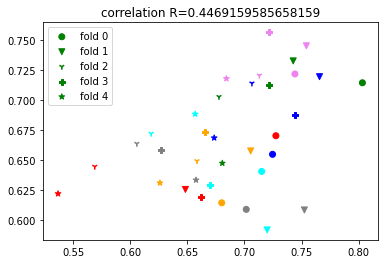

In [37]:
## correlate values
def assign_color_marker(model_name):
    if '0' in model_name:
        m="o"
    elif '1' in model_name:
        m="v"
    elif '2' in model_name:
        m="1"
    elif '3' in model_name:
        m="P"
    elif '4' in model_name:
        m="*"
    else:
        pass
    if 'full_model' in model:
        c='green'
    elif '+finetunning' in model:
        c='red'
    elif '+distance' in model:
        c='blue'
    elif '+classification' in model:
        c='violet'
    elif '+large_augmentation' in model:
        c='grey'
    elif '+mask_augmentation' in model:
        c='cyan'
    elif 'nnunet' in model:
        c='orange'
    else:
        pass
    return c, m

aucs_val_array=[]
aucs_test_array=[]
markers = []
colors=[]
models_name=[]
for model in save_dirs.keys():
    models_name.append(model)
    aucs_val_array.append(aucs_val[model])
    aucs_test_array.append(aucs_test[model])
    c,m= assign_color_marker(model)
    markers.append(m)
    colors.append(c)

cor = np.corrcoef(aucs_val_array, aucs_test_array)[0,1]

aucs_val_array=np.array(aucs_val_array)
aucs_test_array=np.array(aucs_test_array)
colors=np.array(colors)
markers=np.array(markers)
for f in np.arange(5):
    mask_fold = np.array([True if f'fold{f}' in model_name else False for model_name in models_name]).astype(bool)
    plt.scatter(aucs_val_array[mask_fold], aucs_test_array[mask_fold], c=colors[mask_fold], marker=markers[mask_fold][0], label=f'fold {f}')
plt.legend()
plt.title(f'correlation R={cor}')



In [33]:
aucs_val_array[mask_fold]

TypeError: only integer scalar arrays can be converted to a scalar index

In [34]:
aucs_val_array

[0.8032309322033898,
 0.727489406779661,
 0.7245762711864407,
 0.7441737288135593,
 0.7015360169491525,
 0.715042372881356,
 0.6800847457627118,
 0.7426470588235294,
 0.64828431372549,
 0.765686274509804,
 0.7541666666666668,
 0.7524509803921569,
 0.7198529411764705,
 0.7053921568627449,
 0.6776942355889726,
 0.568922305764411,
 0.706516290726817,
 0.713032581453634,
 0.605764411027569,
 0.6182957393483709,
 0.6583959899749373,
 0.721236559139785,
 0.6618279569892472,
 0.7440860215053763,
 0.7215053763440861,
 0.6268817204301075,
 0.6696236559139785,
 0.6653225806451614,
 0.6805885144755576,
 0.536782154722354,
 0.673469387755102,
 0.6841480778357856,
 0.6575700047460844,
 0.6568580920740389,
 0.6260085429520647]

In [32]:
mask_fold

array([ True,  True,  True,  True,  True,  True,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False])

False

In [28]:
models_name

['full_model_fold0',
 '+finetunning_fold0',
 '+distance_fold0',
 '+classification_fold0',
 '+large_augmentation_fold0',
 '+mask_augmentation_fold0',
 'nnunet_fold0',
 'full_model_fold1',
 '+finetunning_fold1',
 '+distance_fold1',
 '+classification_fold1',
 '+large_augmentation_fold1',
 '+mask_augmentation_fold1',
 'nnunet_fold1',
 'full_model_fold2',
 '+finetunning_fold2',
 '+distance_fold2',
 '+classification_fold2',
 '+large_augmentation_fold2',
 '+mask_augmentation_fold2',
 'nnunet_fold2',
 'full_model_fold3',
 '+finetunning_fold3',
 '+distance_fold3',
 '+classification_fold3',
 '+large_augmentation_fold3',
 '+mask_augmentation_fold3',
 'nnunet_fold3',
 'full_model_fold4',
 '+finetunning_fold4',
 '+distance_fold4',
 '+classification_fold4',
 '+large_augmentation_fold4',
 '+mask_augmentation_fold4',
 'nnunet_fold4']

In [35]:
aucs_val_array

[0.8032309322033898,
 0.727489406779661,
 0.7245762711864407,
 0.7441737288135593,
 0.7015360169491525,
 0.715042372881356,
 0.6800847457627118,
 0.7426470588235294,
 0.64828431372549,
 0.765686274509804,
 0.7541666666666668,
 0.7524509803921569,
 0.7198529411764705,
 0.7053921568627449,
 0.6776942355889726,
 0.568922305764411,
 0.706516290726817,
 0.713032581453634,
 0.605764411027569,
 0.6182957393483709,
 0.6583959899749373,
 0.721236559139785,
 0.6618279569892472,
 0.7440860215053763,
 0.7215053763440861,
 0.6268817204301075,
 0.6696236559139785,
 0.6653225806451614,
 0.6805885144755576,
 0.536782154722354,
 0.673469387755102,
 0.6841480778357856,
 0.6575700047460844,
 0.6568580920740389,
 0.6260085429520647]

In [31]:
save_dir

'/rds/project/kw350/rds-kw350-meld/experiments_graph/kw350/23-02-22_DHAM_nnunet/s_0/fold_04/results'